In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [2]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [3]:
@load "../data/sim2data.jld";

In [4]:
# priors #
μβ = fill(0.0, p, q); inv_Vr = [[0.0 0.0]; [0.0 0.0]]; # set Vr^{-1} be zero for the simulation...
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
inv_Lr = [[0.0 0.0]; [0.0 0.0]]; Lμβ = inv_Lr * μβ;

In [5]:
# Some data preparations #
S_ind = [sort(S1_ind), sort(S2_ind)];
S = sort(union(S_ind[1], S_ind[2]));
M_ind = [sort(setdiff(S, S_ind[i])) for i in 1:length(S_ind)];                                  # in S not in S1
M = sort(union(M_ind[1], M_ind[2]));
U = setdiff(1:N, S);                                          # locations without observations 
R = setdiff(S, M);                                            # reference set of NNGP
NR = length(R);
NS = length(S);
NM = length(M);
NU = length(U);


m = 10;                                                       # number of nearest neighbor                       
NN = BuildNN(coords_ord[R, :], m);                       # build nearest neighbor 
nnIndx_col = vcat(NN.nnIndx, 1:NR);                           # the index of columns
nnIndx_row = zeros(Int64, 0);                                               
for i in 2:m
    nnIndx_row = vcat(nnIndx_row, fill(i, i-1))
end
nnIndx_row = vcat(nnIndx_row, repeat((m + 1):NR, inner = m), 1:NR);  # the index of rows

In [6]:
# cross-validation Preparison
# (a) Randomly split S into K folder 
Random.seed!(321); #4321
kf = 5;
parts = kfoldperm(NS,kf);
parts_train = [sort(setdiff(1:NS, parts[i])) for i in 1:kf];
parts_test = [sort(parts[i]) for i in 1:kf];

# (b) Build NN index for training data in ith folder
using RCall
CVNN_train = Array{Any, 1}(undef, kf);
CVNN_test = Array{Any, 1}(undef, kf);
CVnnIndx_col = Array{Any, 1}(undef, kf);
CVnnIndx_row = Array{Any, 1}(undef, kf);
CVMnnIndxLU = Array{Any, 1}(undef, kf); 
CVMnnIndx = Array{Any, 1}(undef, kf);
CVMnndists = Array{Any,1}(undef, kf);
CVIndex_train = Array{Any, 1}(undef, kf);


for i in 1:kf
    ## The training set is the intersection of S/S1 and the reference set R
    CVIndex_train[i] = sort(intersect(S[parts_train[i]], R)); 
end

CVRSMPEind = [filter(x->!(S[parts_test[i][x]] in M_ind[j]), eachindex(parts_test[i])) 
    for i in 1:kf, j in 1:length(M_ind)];

@rput coords_ord
@rput S
@rput m
@rput parts_test
@rput CVIndex_train

for i in 1:kf
    
    # Build NN index for training data in ith folder
    CVNN_train[i] = BuildNN(coords_ord[CVIndex_train[i], :], m);
    CVnnIndx_col[i] = vcat(CVNN_train[i].nnIndx, 1:length(CVIndex_train[i]));
    CVnnIndx_row[i] = zeros(Int64, 0);
    for j in 2:m
        CVnnIndx_row[i] = vcat(CVnnIndx_row[i], fill(j, j-1));
    end
    CVnnIndx_row[i] = vcat(CVnnIndx_row[i], 
        repeat((m + 1):length(CVIndex_train[i]), inner = m), 1:length(CVIndex_train[i]));
        
    # Build nearest neighbor index for holdout locations
    @rput i
    R"""
    library("RANN")
    nn_mod_ho <- nn2(coords_ord[CVIndex_train[[i]], ], coords_ord[S[parts_test[[i]]], ], k = m)
    """
    @rget nn_mod_ho
    CVNN_test[i] = nn_mod_ho;
    CVMnnIndxLU[i] = collect(1:m:(length(parts[i]) * m + 1));
    CVMnnIndx[i] = vec(nn_mod_ho[:nn_idx]');
    CVMnndists[i] = vec(nn_mod_ho[:nn_dists]');
end   

In [7]:
# (a) grid of candidate value
ϕ_grid = vcat(LinRange(3 / sqrt(2), 3 * 12.5 / sqrt(2), 25))
#LinRange(3 / sqrt(2), 3 * 50 / sqrt(2), 20) #LinRange(3 / sqrt(2), 3 * 100 / sqrt(2), 20);
α_grid = vcat(LinRange(0.8, 0.99, 25)) #LinRange(0.75, 1, 10); #LinRange(0.5, 1, 10);

In [8]:
# For loop
CVRMSPE = fill(0.0, length(ϕ_grid), length(α_grid));
ns = length(S_ind[1]) + length(S_ind[2]);
prog = Progress(kf, 1, "Computing initial pass...", 50)
for i in 1:kf
    CVnIndx = length(CVNN_train[i].nnIndx);
    nk = length(parts[i]);
    nr = length(CVIndex_train[i]);
    CVA = Array{Float64}(undef, CVnIndx); CVD = Array{Float64}(undef, nr);
    CVDI_AX = []; CVDI_AY = []; CVVstar = []; CVμstar = [];
    
    CVAtilde = Array{Float64}(undef, nk * m); CVDtilde = Array{Float64}(undef, nk);
    CVAtildeM = [];
    
    for j in 1:length(ϕ_grid) 
        for k in 1:length(α_grid)
            
            # obtain posterior estimators of beta
            getAD_collapse(coords_ord[CVIndex_train[i], :], 
                CVNN_train[i].nnIndx, CVNN_train[i].nnDist, CVNN_train[i].nnIndxLU, 
                ϕ_grid[j], 0.5, α_grid[k], CVA, CVD);
            CVDI_AX = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], CVnnIndx_col[i], 
                    vcat(-CVA, ones(nr))) * X_ord[CVIndex_train[i], :]);
            CVDI_AY = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], CVnnIndx_col[i], 
                    vcat(-CVA, ones(nr))) * Y_ord[CVIndex_train[i], :]);
            CVVstar = inv(Symmetric(CVDI_AX'CVDI_AX + inv_Vr));
            CVμstar = CVVstar * (CVDI_AX'CVDI_AY + inv_Vr * μβ);
            
            # obtain posterior predictions over holded folder
            getAD_collapse(coords_ord[CVIndex_train[i], :], CVMnnIndx[i], 
                CVMnndists[i], CVMnnIndxLU[i],  ϕ_grid[j], 0.5, α_grid[k], CVAtilde, CVDtilde)
            CVAtildeM = sparse(repeat(1:nk, inner = m), CVMnnIndx[i], CVAtilde, nk, nr);
            Y_hold_mean = X_ord[S[parts_test[i]], :] * CVμstar + 
                CVAtildeM * (Y_ord[CVIndex_train[i], :] - X_ord[CVIndex_train[i], :] * CVμstar);
            
            # Calculate RMSPE over observed responses
            for l in 1:q
                CVRMSPE[j, k] = CVRMSPE[j, k] + mean((Y_ord[S[parts_test[i]], l] - 
                        Y_hold_mean[:, l])[CVRSMPEind[i, l]].^2) * length(CVRSMPEind[i, l]) / ns;
            end
        end
    end
    next!(prog) # monitor the progress
end
CVRMSPE = sqrt.(CVRMSPE);

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:16


In [9]:
# cross-validation for choosing delta and phi ...
pick_ind = argmin(CVRMSPE);
ϕ_pick = ϕ_grid[pick_ind[1]]; α_pick = α_grid[pick_ind[2]]; # alpha ranges from 0 to 1. alpha = sigma2 / (sigma2 + tau2)
round.([ϕ_pick, α_pick], digits = 3)

2-element Array{Float64,1}:
 7.204
 0.903

In [10]:
# Prepare for the log-likelihood in MH

# Build μ* V* Ψ* v* for prior
nIndx = length(NN.nnIndx);
A = Array{Float64}(undef, nIndx); D = Array{Float64}(undef, NR);
getAD_collapse(coords_ord[R, :], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_pick, 0.5, α_pick, A, D);
DI_AX = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(NR))) * X_ord[R, :]);
DI_AY = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(NR))) * Y_ord[R, :]);
Vstar = inv(Symmetric(DI_AX'DI_AX + inv_Vr));
μstar = Vstar * (DI_AX'DI_AY + inv_Vr * μβ);
Lμstar = cholesky(Vstar).L \ μstar;
Ψstar = ΨΣ + DI_AY'DI_AY + Lμβ'Lμβ - Lμstar'Lμstar;
νstar = νΣ + NR;
inv_Vstar = inv(Vstar);
logdet_Vstar = logdet(Vstar);

# Construct AMtilde DMtilde for observations on M for updating Σ from prior Σ | YR 
using RCall
@rput coords_ord
@rput R
@rput M
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(coords_ord[R, ], coords_ord[M, ], k = m)
"""
@rget nn_mod_ho
AMtilde = Array{Float64}(undef, NM * m); DMtilde = Array{Float64}(undef, NM);
MnnIndxLU = collect(1:m:(NM * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');
getAD_collapse(coords_ord[R, :], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, 
    ϕ_pick, 0.5, α_pick, AMtilde, DMtilde)
AMtildeM = sparse(repeat(1:NM, inner = m), MnnIndx, AMtilde, NM, NR);


# Construct AMtilde DMtilde for U 
@rput coords_ord
@rput R m
@rput U

R"""
library("RANN")
nn_mod_ho2 <- nn2(coords_ord[R, ], coords_ord[U, ], k = m)
"""
@rget nn_mod_ho2
NU = length(U);
A2tilde = Array{Float64}(undef, NU * m); D2tilde = Array{Float64}(undef, NU);
MnnIndxLU2 = collect(1:m:(NU * m + 1));
MnnIndx2 = vec(nn_mod_ho2[:nn_idx]');
getAD_collapse(coords_ord[R, :], MnnIndx2, vec(nn_mod_ho2[:nn_dists]'), MnnIndxLU2, 
    ϕ_pick, 0.5, α_pick, A2tilde, D2tilde)
A2tildeM = sparse(repeat(1:NU, inner = m), MnnIndx2, A2tilde, NU, NR);
D2tildeD = Diagonal(sqrt.(D2tilde));


In [11]:
# Preallocation for posterior samples  of Σ#
Random.seed!(1);
N_sam = 20000; N_burnin = Integer(trunc(N_sam * 0.75));
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam + 1);
L_sam = Array{Float64, 3}(undef, q, q, N_sam + 1);
A_sam = Array{Float64, 1}(undef, N_sam); # acceptance rate
llh_sam = Array{Float64, 1}(undef, N_sam + 1); # record log-likelihood 

cholΣ_sam = Array{Float64, 2}(undef, q, q);

#Preallocation for posterior samples of vecβ#
vec_β_sam = Array{Float64, 2}(undef, q * p, N_sam - N_burnin);

#Preallocation for posterior samples of missing value over M#
Y_miss_sam = Array{Float64, 2}(undef, length(M_ind[1]) + length(M_ind[2]), N_sam - N_burnin);

#Preallocation for posterior samples of missing value over U#
Y_U_sam = Array{Float64, 3}(undef, NU, q, N_sam - N_burnin);

# check the prior of Σ | YR
Σ_prior_sam = rand(InverseWishart(νstar, Ψstar), 500);
L_prior_sam = [cholesky(Σ_prior_sam[i]).L[j] for i in 1:500, j in 1:(q * q)];
Σ_sam[:, :, 1] = Ψstar / (νstar - q - 1);
L_sam[:, :, 1] = cholesky(Σ_sam[:, :, 1]).L
scale_L = cholesky(cov(L_prior_sam[:, [1, 2, 4]]) * 2.38^2).L;

In [12]:
# build H2 H1 YM_mean and vec(YM-YM_mean)

M_sort = fill(0, N, q);
M_sort[S_ind[1], 1] .= 1; M_sort[S_ind[2], 2] .= 1;
M_sort_index = (M_sort[:, 1] * (2^0) +  M_sort[:, 2] * (2^1))[M];
Dict_obs = Dict(2^0 => [1], 2^1 => [2], (2^0 + 2^1)=> [1, 2]);
M_obs_index = [Dict_obs[M_sort_index[i]] for i in 1:NM];
Dict_miss = Dict(2^0 => [2], 2^1 => [1], 0 => [1, 2]);
M_miss_index = [Dict_miss[M_sort_index[i]] for i in 1:NM];
invDele = Array{Float64, 1}(undef, NM);
L = sum(M_sort[M, :]);
H1 = fill(0.0, L, q * p);
H2 = spzeros(L, q * NR);
vec_YM = zeros(L);
DMl = zeros(L);
l = 1;
for i in 1:NM
    for j in 1:q
        if M_sort[M[i], j] == 1
            H1[l, (j - 1) * p .+ (1:p)] = X_ord[M[i], :];
            H2[l, (j - 1) * NR .+ (1:NR)] = AMtildeM[i, :];
            vec_YM[l] = Y_ord[M[i], j];
            DMl[l] = DMtilde[i]; 
            l = l + 1;
        end
    end
end
H1 = H1 - H2 * kron(Diagonal(ones(q)), X_ord[R, :]);
YM_mean = H1 * vec(μstar) + H2 * vec(Y_ord[R, :]);
vec_YM_YM_mean = vec_YM - YM_mean;
Ystar = vcat(vec(DI_AY), (vec_YM - H2 * vec(Y_ord[R, :])) ./ (sqrt.(DMl)), vec(Lμβ));
Xstar = vcat(kron(Diagonal(ones(q)), DI_AX), 
    Diagonal(1 ./ sqrt.(DMl)) * H1, kron(Diagonal(ones(q)), inv_Lr));

In [13]:
# MCMC algorithm for obtaining posterior sample of Σ#
Random.seed!(123);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    if l == 1
        cholΣ_sam = cholesky(Σ_sam[:, :, l]);
        Dic_diag = Dict(2^0 => (1 / (Σ_sam[1, 1, l])), 2^1 => (1 / (Σ_sam[2, 2, l])));
        invDele = [(Dic_diag[M_sort_index[i]] / DMtilde[i]) for i in 1:NM ];
        invD = Diagonal(invDele); #sparse(1:NM, 1:NM, invDele);
        logdetD = -sum(log.(invDele));
        #logdetD = -sum([log(det(Dic_diag[M_sort_index[i]] ./ DMtilde[i]))  for i in 1:NM]);
        inv_V_prior = kron(inv(cholΣ_sam), inv_Vstar);
        logdet_V_prior = p * logdet(cholΣ_sam) + q * logdet_Vstar;
        chol_V_update = cholesky(Symmetric(inv_V_prior + transpose(H1) * invD * H1));
        u = chol_V_update.L \ (transpose(H1) * (invD * vec_YM_YM_mean));
        llh_sam[1] = logpdf(InverseWishart(νstar, Ψstar), Σ_sam[:, :, l]) - 
            0.5 * (logdet(chol_V_update) + logdet_V_prior + logdetD + 
            vec_YM_YM_mean' * (invD * vec_YM_YM_mean) - u'u ) +  
        sum([(q - i + 1) * log(abs(L_sam[i, i, 1])) for i in 1:q]);
    end
    
    
    # use metropolis-hasting to update range
    v_old = [L_sam[1, 1, l], L_sam[2, 1, l], L_sam[2, 2, l]];
    v_new = v_old + scale_L * rand(Normal(), 3);
    L_sam[1, 1, l + 1] = v_new[1];
    L_sam[2, 1, l + 1] = v_new[2];
    L_sam[2, 2, l + 1] = v_new[3];
    L_sam[1, 2, l + 1] = 0.0;
    Σ_sam[:, :, l + 1] = Symmetric(L_sam[:, :, l + 1] * transpose(L_sam[:, :, l + 1]));
    cholΣ_sam = cholesky(Σ_sam[:, :, l + 1]);
    Dic_diag = Dict(2^0 => (1 / (Σ_sam[1, 1, l + 1])), 2^1 => (1 / (Σ_sam[2, 2, l + 1])));
    invDele = [(Dic_diag[M_sort_index[i]] / DMtilde[i]) for i in 1:NM ];
    invD = Diagonal(invDele); #sparse(1:NM, 1:NM, invDele);
    logdetD = -sum(log.(invDele));
    inv_V_prior = kron(inv(cholΣ_sam), inv_Vstar);
    logdet_V_prior = p * logdet(cholΣ_sam) + q * logdet_Vstar;
    chol_V_update = cholesky(Symmetric(inv_V_prior + transpose(H1) * invD * H1));
    u = chol_V_update.L \ transpose(H1) * invD * vec_YM_YM_mean;
    llh_sam[l + 1] = logpdf(InverseWishart(νstar, Ψstar), Σ_sam[:, :, l + 1]) - 
        0.5 * (logdet(chol_V_update) + logdet_V_prior + logdetD + 
        vec_YM_YM_mean' * (invD * vec_YM_YM_mean) - u'u ) + 
        sum([(q - i + 1) * log(abs(L_sam[i, i, l + 1])) for i in 1:q]);
    A_sam[l] = min(exp(llh_sam[l + 1] - llh_sam[l]), 1.0); # acceptance rate
    if rand(1)[1] > A_sam[l]
       # Don't update
        L_sam[:, :, l + 1] = L_sam[:, :, l]; 
        Σ_sam[:, :, l + 1] = Σ_sam[:, :, l]; 
        llh_sam[l + 1] = llh_sam[l];
    end  
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:03


In [14]:
mean(A_sam)

0.1091710222020653

In [15]:
# generate the posterior samples of β and prediction over S with missing observations and over tested locations#
Random.seed!(123);
prog = Progress(N_sam - N_burnin, 1, "Computing initial pass...", 50)
for l in (N_burnin + 1):N_sam
    
    cholΣ_sam = cholesky(Σ_sam[:, :, l]);
    Dic_diag = Dict(2^0 => (1 / Σ_sam[1, 1, l]), 2^1 => (1 / Σ_sam[2, 2, l]), 
        (2^0 + 2^1)=> sparse(inv(cholΣ_sam)));
    invDele = [(Dic_diag[M_sort_index[i]] / DMtilde[i]) for i in 1:NM];
    inv_Vη = blockdiag(kron(Dic_diag[(2^0 + 2^1)], sparse(1I, NR, NR)), 
        sparse(1:NM, 1:NM, invDele), kron(Dic_diag[(2^0 + 2^1)], sparse(1I, p, p))); 
    chol_inv_Vβstar = cholesky(Symmetric(Xstar' * (inv_Vη * Xstar)));
    vec_β_sam[:, l - N_burnin] = chol_inv_Vβstar.U \ (chol_inv_Vβstar.L \ (Xstar' * (inv_Vη * Ystar)) +
        rand(Normal(), p * q));
    
    # update posterior predictions over S with missing observations
    β_sam = reshape(vec_β_sam[:, l - N_burnin], p, q);
    
    MeanYM = X_ord[M, :] * β_sam + AMtildeM * (Y_ord[R, :] - X_ord[R, :] * β_sam);
    
    Dic_diag_cond_std = Dict(2^0 => sqrt(Σ_sam[2, 2, l] - Σ_sam[2, 1, l] / Σ_sam[:, :, l][1, 1] * Σ_sam[1, 2, l]), 
        2^1 => sqrt(Σ_sam[1, 1, l] - Σ_sam[1, 2, l] / Σ_sam[2, 2, l] * Σ_sam[2, 1, l]));
    Dic_diag_cond_cor = Dict(2^0 => Σ_sam[2, 1, l] / Σ_sam[1, 1, l], 
        2^1 => Σ_sam[1, 2, l] / Σ_sam[2, 2, l]);
    j = 1; 
    for i in 1:NM
        Y_miss_sam[j:(j + length(M_miss_index[i]) - 1), l - N_burnin] = 
            MeanYM[i, M_miss_index[i]] + Dic_diag_cond_cor[M_sort_index[i]] *
            (Y_ord[M[i], M_obs_index[i]] - MeanYM[i, M_obs_index[i]]) + 
            sqrt(DMtilde[i]) * rand(Normal(0, Dic_diag_cond_std[M_sort_index[i]]), 1);
        j = j + length(M_miss_index[i]);
    end
    
    # update posterior predictions over locations with no observations
    Y_U_sam[:, :, l - N_burnin] = X_ord[U, :] * β_sam + A2tildeM * (Y_ord[R, :] - X_ord[R, :] * β_sam) + 
        D2tildeD * rand(Normal(), NU, q) * cholΣ_sam.U
    
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:10


In [16]:
NM

342

In [17]:
NR

829

# MCMC Chain check

In [18]:
# packages for diagnostic test
using StatsPlots
using MCMCChains
using PrettyTables

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840


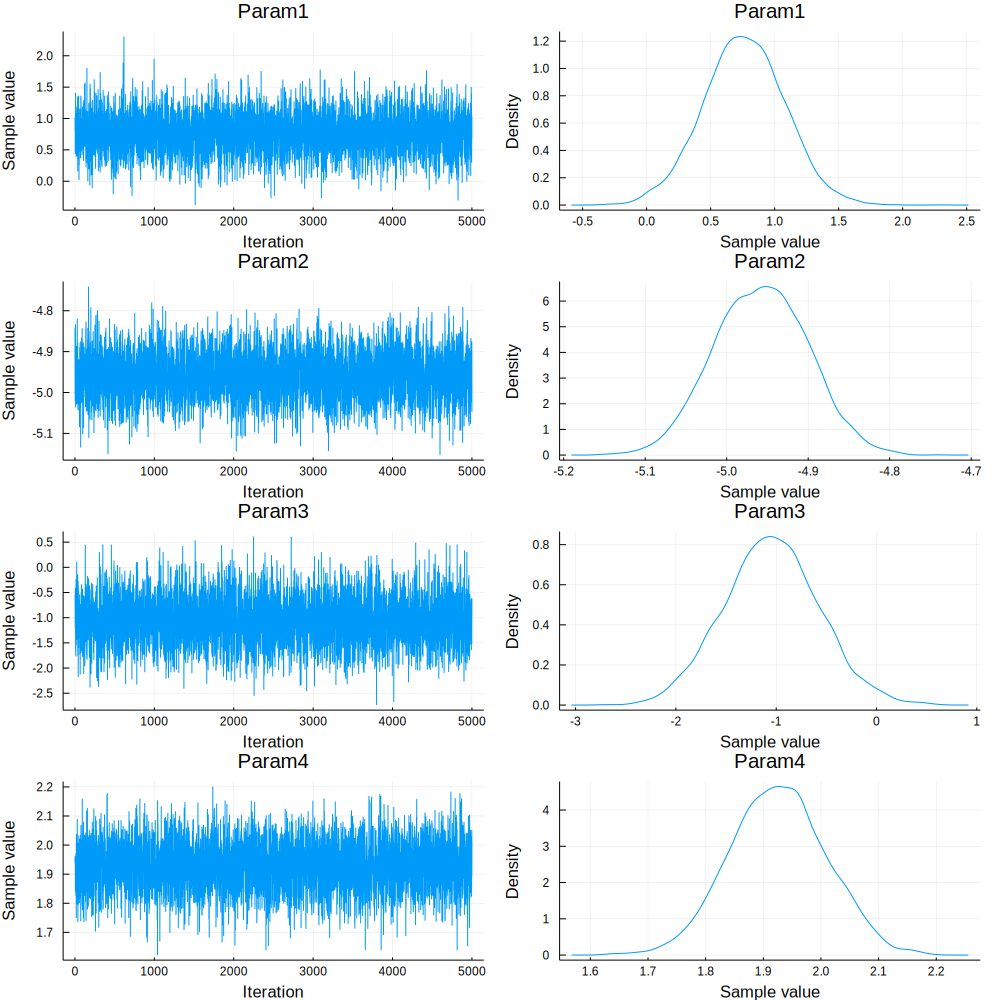

In [19]:
vec_β_pos_sam = Array{Float64, 3}(undef, N_sam - N_burnin, p * q, 1);
vec_β_pos_sam[:, :, 1] = hcat(vec_β_sam[1, :], vec_β_sam[2, :], vec_β_sam[3, :], vec_β_sam[4, :]);
vec_β_chain = Chains(vec_β_pos_sam);
pβ = plot(vec_β_chain)

In [20]:
β

2×2 Array{Float64,2}:
  1.0  -1.0
 -5.0   2.0

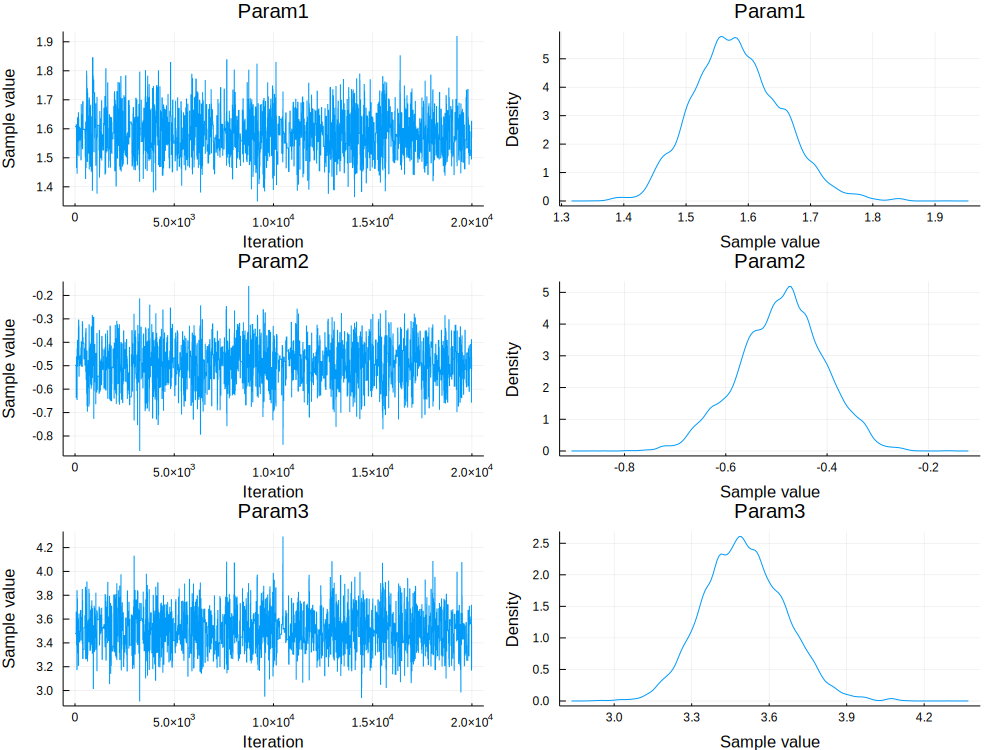

In [21]:
truncindex = 1;#Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, Integer(q * (q + 1) / 2), 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[2, 1, truncindex:N_sam], 
    Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [22]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
  0.683048  -0.615677
 -0.615677   4.51697 

In [23]:
Σ

2×2 Array{Float64,2}:
 0.3  0.0
 0.0  0.2

In [24]:
Σ_sam[:, :, 1]

2×2 Array{Float64,2}:
  1.60737   -0.498492
 -0.498492   3.478   

# Posterior Inference 

In [25]:
Y_m_pos_qt = Array{Float64, 2}(undef, length(M_ind[1]) + length(M_ind[2]), 3);
Y_m_pos_mean = Array{Float64, 1}(undef, length(M_ind[1]) + length(M_ind[2]));
Y_m_pos_var = Array{Float64, 1}(undef, length(M_ind[1]) + length(M_ind[2]));
for i in 1:(length(M_ind[1]) + length(M_ind[2]))
    Y_m_pos_qt[i, :] = quantile(Y_miss_sam[i, 1:(N_sam - N_burnin)], [0.025, 0.5, 0.975]);
    Y_m_pos_mean[i] = mean(Y_miss_sam[i, 1:(N_sam - N_burnin)]);
    Y_m_pos_var[i] = var(Y_miss_sam[i, 1:(N_sam - N_burnin)]);
end

Y_U_pos_qt = Array{Float64, 3}(undef, NU, q, 3);
Y_U_pos_mean = Array{Float64, 2}(undef, NU, q);
Y_U_pos_var = Array{Float64, 2}(undef, NU, q);
for j in 1:q
    for i in 1:NU
        Y_U_pos_qt[i, j, :] = quantile(Y_U_sam[i, j, 1:(N_sam - N_burnin)], [0.025, 0.5, 0.975]);
        Y_U_pos_mean[i, j] = mean(Y_U_sam[i, j, 1:(N_sam - N_burnin)]);
        Y_U_pos_var[i, j] = var(Y_U_sam[i, j, 1:(N_sam - N_burnin)]);
    end
end

# count the covarage of 95% CI #
count = fill(0.0, 2);l = 0;
for i in 1: NM
    for j in 1:length(M_miss_index[i])
        
        if (M_miss_index[i] == [1])
            count[1] = count[1] + ((Y_m_pos_qt[l + j, 1] < Y_ord[M[i], M_miss_index[i][j]]) && 
                        (Y_m_pos_qt[l + j, 3] > Y_ord[M[i], M_miss_index[i][j]]));
        else
            count[2] = count[2] + ((Y_m_pos_qt[l + j, 1] < Y_ord[M[i], M_miss_index[i][j]]) && 
                        (Y_m_pos_qt[l + j, 3] > Y_ord[M[i], M_miss_index[i][j]]));
        end
    end
    l = l + length(M_miss_index[i]);
end

count2 = fill(0.0, 2);l = 0;
# count the covarage of 95% CI for predictions over U#
for j in 1:q
    for i in 1:NU
        count2[j] = count2[j] + 
        ((Y_U_pos_qt[i, j, 1] < Y_ord[U[i], j]) && 
            (Y_U_pos_qt[i, j, 3] > Y_ord[U[i], j]))
    end
end
print(round.((count .+ count2) ./ [length(M_ind[1]) + NU, length(M_ind[2]) + NU], digits = 3))
print(round((sum(count) + sum(count2))/(length(M_ind[1]) + 2* NU + length(M_ind[2])), digits = 3))

[0.945, 0.955]0.95

In [26]:
# calculate root mean square predictive error #
SPE = Array{Float64, 1}(undef, (length(M_ind[1]) + length(M_ind[2])));
l = 0;
for i in 1: NM
    for j in 1:length(M_miss_index[i])
        SPE[l + j] = (Y_ord[M[i], M_miss_index[i][j]] - Y_m_pos_mean[l + j])^2;
    end
    l = l + length(M_miss_index[i]);
end
RMSPE = sqrt((sum(SPE) + sum((Y_ord[U, :] - Y_U_pos_mean).^2)) / 
    (length(M_ind[1]) + length(M_ind[2]) + q * NU));

In [27]:
# calculate root mean square predictive error #
SPE = fill(0.0, 2);
l = 0;
for i in 1: NM
    for j in 1:length(M_miss_index[i])
        if M_miss_index[i][j] == 1
            SPE[1] = SPE[1] + (Y_ord[M[i], M_miss_index[i][j]] - Y_m_pos_mean[l + j])^2;
        else 
            SPE[2] = SPE[2] + (Y_ord[M[i], M_miss_index[i][j]] - Y_m_pos_mean[l + j])^2;
        end
    end
    l = l + length(M_miss_index[i]);
end
RMSPE1 = sqrt((SPE[1] + sum((Y_ord[U, 1] - Y_U_pos_mean[:, 1]).^2)) / 
    (length(M_ind[1]) + NU));
RMSPE2 = sqrt((SPE[2] + sum((Y_ord[U, 2] - Y_U_pos_mean[:, 2]).^2)) / 
    (length(M_ind[2]) + NU));

In [28]:
print(round.([RMSPE1 RMSPE2 RMSPE], digits = 3))

[0.643 0.948 0.81]

In [29]:
# CRPS #

SCRPS_M = fill(0.0, 2);
l = 0;
for i in 1:NM
    for j in 1:length(M_miss_index[i])
        if M_miss_index[i][j] == 1
            SCRPS_M[1] = SCRPS_M[1] + (sqrt(Y_m_pos_var[l + j]) * ( 1 /sqrt(π) - 
                2 * pdf(Normal(), (Y_ord[M[i], 1] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) -
                ((Y_ord[M[i], 1] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) * 
                (2 * cdf(Normal(), (Y_ord[M[i], 1] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) - 1 )));
        else 
            SCRPS_M[2] = SCRPS_M[2] + (sqrt(Y_m_pos_var[l + j]) * ( 1 /sqrt(π) - 
                2 * pdf(Normal(), (Y_ord[M[i], 2] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) -
                ((Y_ord[M[i], 2] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) * 
                (2 * cdf(Normal(), (Y_ord[M[i], 2] - Y_m_pos_mean[l + j]) / sqrt(Y_m_pos_var[l + j])) - 1 )));
        end
    end
    l = l + length(M_miss_index[i]);
end

CRPS_U = [(sqrt(Y_U_pos_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[U[i], j] - Y_U_pos_mean[i, j]) / sqrt(Y_U_pos_var[i, j])) -
        ((Y_ord[U[i], j] - Y_U_pos_mean[i, j]) / sqrt(Y_U_pos_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[U[i], j] - Y_U_pos_mean[i, j]) / sqrt(Y_U_pos_var[i, j])) - 1 )))
        for i in 1:NU, j in 1:q];

CRPS1 = (sum(CRPS_U[:, 1]) + SCRPS_M[1]) / (length(M_ind[1]) + NU);
CRPS2 = (sum(CRPS_U[:, 2]) + SCRPS_M[2]) / (length(M_ind[2]) + NU);
CRPS = (sum(CRPS_U) + sum(SCRPS_M))/(2 * NU + length(M_ind[1]) + (length(M_ind[2])));
round.([CRPS1 CRPS2 CRPS], digits = 3)

1×3 Array{Float64,2}:
 -0.366  -0.535  -0.45

In [30]:
# INT #
SINT_M = fill(0.0, 2);
l = 0;
for i in 1:NM
    for j in 1:length(M_miss_index[i])
        if M_miss_index[i][j] == 1
            SINT_M[1] = SINT_M[1] + ((Y_m_pos_qt[l + j, 3] - Y_m_pos_qt[l + j, 1]) + 
                (2 / 0.05)*(Y_m_pos_qt[l + j, 1] - Y_ord[M[i], 1]) * 
                (Y_ord[M[i], 1] < Y_m_pos_qt[l + j, 1]) + 
                (2 / 0.05)*(Y_ord[M[i], 1] - Y_m_pos_qt[l + j, 3]) * 
                (Y_ord[M[i], 1] > Y_m_pos_qt[l + j, 3]));    
        else 
            SINT_M[2] = SINT_M[2] + ((Y_m_pos_qt[l + j, 3] - Y_m_pos_qt[l + j, 1]) + 
                (2 / 0.05) * (Y_m_pos_qt[l + j, 1] - Y_ord[M[i], 2]) * 
                (Y_ord[M[i], 2] < Y_m_pos_qt[l + j, 1]) + 
                (2 / 0.05) * (Y_ord[M[i], 2] - Y_m_pos_qt[l + j, 3]) * 
                (Y_ord[M[i], 2] > Y_m_pos_qt[l + j, 3]));
        end
    end
    l = l + length(M_miss_index[i]);
end

INT_U = [((Y_U_pos_qt[i, j, 3] - Y_U_pos_qt[i, j, 1]) + 
    (2 / 0.05)*(Y_U_pos_qt[i, j, 1] - Y_ord[U[i], j]) * (Y_ord[U[i], j] < Y_U_pos_qt[i, j, 1]) + 
    (2 / 0.05)*(Y_ord[U[i], j] - Y_U_pos_qt[i, j, 3]) * (Y_ord[U[i], j] > Y_U_pos_qt[i, j, 3]))
    for i in 1: NU, j in 1:q];

INT1 = (sum(INT_U[:, 1]) + SINT_M[1]) / (length(M_ind[1]) + NU);
INT2 = (sum(INT_U[:, 2]) + SINT_M[2]) / (length(M_ind[2]) + NU);
INT = (sum(INT_U) + sum(SINT_M))/(2 * NU + length(M_ind[1]) + (length(M_ind[2])));

round.([INT1 INT2 INT], digits = 3)

1×3 Array{Float64,2}:
 3.031  4.324  3.678

In [31]:
NM

342

In [32]:
N_Inf_burn = Integer(trunc(N_sam / 2));
summary_table = Array{Float64, 2}(undef, 10, 5);
summary_table[1, :] = vcat(β[1, 1], mean(vec_β_sam[1, :]),
    quantile(vec_β_sam[1, :], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[1, 2], mean(vec_β_sam[3, :]),
    quantile(vec_β_sam[3, :], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(β[2, 1], mean(vec_β_sam[2, :]),
    quantile(vec_β_sam[2, :], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(β[2, 2], mean(vec_β_sam[4, :]),
    quantile(vec_β_sam[4, :], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(Σ[1, 1], mean((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(Σ[1, 2], mean((1 / α_pick - 1.0) .* Σ_sam[1, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(Σ[2, 2], mean((1 / α_pick - 1.0) .*Σ_sam[2, 2, N_Inf_burn:(N_sam + 1)]),
    quantile((1 / α_pick - 1.0) .*Σ_sam[2, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(covω[1, 1],  mean(Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile(Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(covω[1, 2],  mean(Σ_sam[1, 2, N_Inf_burn:N_sam]),
    quantile(Σ_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(covω[2, 2],  mean(Σ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile(Σ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]", 
    "cov(ω)[1, 1]", "cov(ω)[1, 2]", "cov(ω)[2, 2]"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|              |   true |   mean | median |   2.5% |  97.5% |
|--------------|--------|--------|--------|--------|--------|
|      β[1, 1] |    1.0 |  0.761 |  0.762 |   0.13 |  1.376 |
|      β[1, 2] |   -1.0 | -1.048 | -1.051 | -1.971 |  -0.09 |
|      β[2, 1] |   -5.0 | -4.958 | -4.958 | -5.068 | -4.847 |
|      β[2, 2] |    2.0 |  1.925 |  1.926 |  1.763 |  2.087 |
|      Σ[1, 1] |    0.3 |   0.17 |   0.17 |  0.156 |  0.185 |
|      Σ[1, 2] |    0.0 | -0.052 | -0.052 | -0.071 | -0.036 |
|      Σ[2, 2] |    0.2 |  0.376 |  0.375 |  0.344 |  0.411 |
| cov(ω)[1, 1] |  0.683 |   1.58 |  1.579 |  1.451 |  1.719 |
| cov(ω)[1, 2] | -0.616 | -0.488 | -0.483 | -0.656 |  -0.33 |
| cov(ω)[2, 2] |  4.517 |    3.5 |  3.491 |  3.203 |  3.826 |
